# Técnicas de NLP para representar texto

Marcos Dayan Mann

A01782876

## Importación de todas las librerías que necesitamos
Tanto de preprocesamiento como NLTK, como algunos modelos de SKlearn para validar nuestro preprocesamiento


In [78]:
import pandas as pd
import numpy as np
import re
import emoji
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nltk
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, FreqDist

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse

# Word Embeddings
from gensim.models import Word2Vec, FastText
from gensim.models.phrases import Phrases, Phraser

# Transformers para BERT
from transformers import BertTokenizer, BertModel
import torch

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### Descarga de Recursos NLTK

Es necesario descargar los recursos de NLTK para realizar tokenización, lematización, análisis de sentimientos y etiquetado POS.

In [79]:
download_list = [
    'punkt',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'omw-1.4',
    'sentiwordnet',
    'vader_lexicon'
]
    
for item in download_list:
    try:
        nltk.download(item, quiet=True)
    except:
        print(f"No se pudo descargar {item}")

print("Recursos NLTK descargados correctamente")

Recursos NLTK descargados correctamente


## 1. Pipeline de Preprocesamiento de Texto

En esta sección se diseñé un pipeline completo de preprocesamiento para sacarle el mayor provecho al significado del vocabulario, eliminar el ruido, links, emojis, y cosas que hacen el texto menos procesable y más ambiguo, esto con diferentes herramientas como procesamiento con nltk, expresiones regulares, lematización, entre otras herramientas que vimos en clase.

Proceso del pipeline:

1. Manejo de caracteres especiales y emojis (codificación utf-8)
2. Reducción de vocabulario redundante y pasar el texto a minúsculas
3. Extracción y limpieza estructurada de URLs, menciones, hashtags, todo ésto con regex
4. Eliminación de stopwords para hacer menos ambiguos los textos
5. Parsear emojis por palabras clave, agarré emojis comunes que expresan sentimientos positivos y negativos, para tratar de sacar un poco m+as de contexto de los emojis
6. Identificación de categorías gramaticales para lematización contextual con Pos Tagging
7. Lematización y stemming a los textos 

### Carga de Datos

Cargamos los archivos de entrenamiento y prueba, manteniendo el formato original con headers. Los datos contienen tweets etiquetados con diferentes categorías de sentimiento.

In [80]:
# cargar datos
train_df = pd.read_csv('originallTraining.txt', sep='\t', header=None, 
                       names=['tweet_id', 'user_id', 'sentiment', 'text'])
test_df = pd.read_csv('originalTest.txt', sep='\t', header=None,
                      names=['tweet_id', 'user_id', 'sentiment', 'text'])

print(f"Datos de entrenamiento: {train_df.shape[0]} tweets")
print(f"Datos de prueba: {test_df.shape[0]} tweets")
print(f"\nCategorías de sentimiento en entrenamiento:")
print(train_df['sentiment'].value_counts())
print(f"\nPrimeros 3 ejemplos:")
train_df.head(3)

Datos de entrenamiento: 6152 tweets
Datos de prueba: 974 tweets

Categorías de sentimiento en entrenamiento:
sentiment
positive                2248
objective-OR-neutral    1106
neutral                 1079
objective                863
negative                 856
Name: count, dtype: int64

Primeros 3 ejemplos:


,tweet_id,user_id,sentiment,text
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
2,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...


In [81]:
# decidí englobar el pipeline en una clase para que sea más fácil aplicarlo muchas veces, para training y testing, solo creando una instancia de la clase y llamando al método "preprocess()"
class TextPreprocessor:
    """
    Pipeline completo de preprocesamiento de texto para análisis de sentimientos.
    """
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        
        # Stopwords de nltk
        self.stop_words = set(stopwords.words('english'))
        # Dejar palabras que indican sentimiento (como lo que vimos en clase, como son tweets, de por si no tienen mucho contexto, entonces dejamos algunas stopwords)
        sentiment_words = {'not', 'no', 'nor', 'never', 'neither', 'nobody', 
                          'none', 'nothing', 'very', 'too', 'so', 'more', 'most'}
        self.stop_words = self.stop_words - sentiment_words
        
        print("TextPreprocessor inicializado")
    
    def decode_text_utf8(self, text):
        """decodificación en utf-8"""
        if isinstance(text, bytes):
            return text.decode('utf-8', errors='ignore')
        return str(text)
    
    def extract_features(self, text):
        """extracción de características especiales"""
        features = {
            'urls': re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text),
            'mentions': re.findall(r'@\w+', text),
            'hashtags': re.findall(r'#\w+', text),
            'emojis': [char for char in text if char in emoji.EMOJI_DATA]
        }
        return features

    def clean_with_regex(self, text):
        """Limpieza con patrones Regex"""
        # Reemplazar URLs con token especial
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' URL ', text)
        
        # contenido de hashtags djando la palabra
        text = re.sub(r'#(\w+)', r'\1', text)
        #  menciones de redes sociales
        text = re.sub(r'@\w+', '', text)
        
        # números
        text = re.sub(r'\d+', ' NUM ', text)
        # Remover caracteres repetidos tipo holaaaa -> hola
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        
        return text
    
    def handle_case(self, text):
        """todo a minúsculas"""
        # Convertir a minúsculas para normalizar
        return text.lower()
    
    def handle_punctuation(self, text, preserve_sentiment=True):
        """quitar puntuación y manejar signos de exclamación e interrogación"""
        if preserve_sentiment:
            text = text.replace('!', ' EXCLAMATION ')
            text = text.replace('?', ' QUESTION ')
        
        # Remover otra puntuación
        text = re.sub(r'[^\w\s]', ' ', text)
        
        return text
    
    def tokenize(self, text):
        """tokenización"""
        # primero sentence y luego word como vimos en clase, ayuda a que se separen mejor los tokens
        sentence_tokens = sent_tokenize(text)
        tokens = [word_tokenize(sentence) for sentence in sentence_tokens]
        return tokens
    
    def remove_stopwords(self, tokens):
        """remover stopwords"""
        if len(tokens) == 1:
            tokens = tokens[0]
        return [token for token in tokens if token not in self.stop_words]
    
    def get_wordnet_pos(self, treebank_tag):
        """PoS tags"""
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    def lemmatize_with_pos(self, tokens):
        """lematización con POS tagging"""
        # Obtener POS tags
        pos_tags = pos_tag(tokens)
        
        # Lematizar según el POS tag
        lemmatized = []
        for token, tag in pos_tags:
            wordnet_pos = self.get_wordnet_pos(tag)
            lemmatized.append(self.lemmatizer.lemmatize(token, pos=wordnet_pos))
        
        return lemmatized
    
    def stem_tokens(self, tokens):
        """stemming"""
        return [self.stemmer.stem(token) for token in tokens]
    
    def preprocess(self, text, use_stemming=False):
        """preprocesamiento completo en pipeline"""
        text = self.decode_text_utf8(text)
        features = self.extract_features(text) # para analizar, no se usan para el preprocesamiento
        text = self.clean_with_regex(text)
        text = self.handle_case(text)
        text = self.handle_punctuation(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        # o stemming o lematización, se va a probar con cada una
        if use_stemming:
            tokens = self.stem_tokens(tokens)
        else:
            tokens = self.lemmatize_with_pos(tokens)
        # tokens = [token for token in tokens if len(token) > 2]
        
        return ' '.join(tokens), features


preprocessor = TextPreprocessor()

TextPreprocessor inicializado


### Demostración del Pipeline

Probamos el pipeline con ejemplos reales del dataset para verificar su funcionamiento.

In [82]:
# Ejemplos de preprocesamiento
print("proeba del pipeline de preprocesamiento")

for i in range(3):
    original = train_df.iloc[i]['text']
    processed, features = preprocessor.preprocess(original)
    
    print(f"Ejemplo {i+1}:")
    print(f"Sentimiento: {train_df.iloc[i]['sentiment']}")
    print(f"Original:\n{original}")
    print(f"Procesado:\n{processed}")
    print(f"Características extraídas:")
    for key, value in features.items():
        if value:
            print(f"  - {key}: {value}")
    print()

proeba del pipeline de preprocesamiento
Ejemplo 1:
Sentimiento: positive
Original:
Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
Procesado:
gas house hit num num EXCLAMATION EXCLAMATION go chapel hill sit
Características extraídas:

Ejemplo 2:
Sentimiento: negative
Original:
Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
Procesado:
iranian general say israel iron dome deal missile keep talk like may end find
Características extraídas:

Ejemplo 3:
Sentimiento: positive
Original:
with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
Procesado:
j davlar num th main rival team poland hopefully make successful end tough week training tomorrow
Características extraídas:



### Aplicación del Pipeline a Todo el Dataset

Aplicamos el preprocesamiento a todos los tweets de entrenamiento y prueba.

In [83]:
# Aplicar preprocesamiento a todo el dataset
print("Preprocesando datos de entrenamiento...")
train_df['processed_text'] = train_df['text'].apply(lambda x: preprocessor.preprocess(x)[0])

print("Preprocesando datos de prueba...")
test_df['processed_text'] = test_df['text'].apply(lambda x: preprocessor.preprocess(x)[0])

# Simplificar etiquetas de sentimiento
# def simplify_sentiment(sentiment):
#     """Simplifica las categorías de sentimiento"""
#     sentiment = sentiment.lower().strip()
#     if 'positive' in sentiment:
#         return 'positive'
#     elif 'negative' in sentiment:
#         return 'negative'
#     elif 'objective' in sentiment:
#         return 'objective'
#     else:
#         return 'neutral'

# train_df['sentiment'] = train_df['sentiment'].apply(simplify_sentiment)
# test_df['sentiment'] = test_df['sentiment'].apply(simplify_sentiment)


# Preparar datos
X_train = train_df['processed_text']
X_test = test_df['processed_text']
y_train = train_df['sentiment']
y_test = test_df['sentiment']

print(f"\nPreprocesamiento completado")
print(f"Training: {len(X_train)} tweets | Test: {len(X_test)} tweets")
print(f"Distribución de sentimientos:")
print(train_df['sentiment'].value_counts())
train_df[['text', 'processed_text', 'sentiment']].head()

Preprocesando datos de entrenamiento...
Preprocesando datos de prueba...
Preprocesando datos de prueba...

Preprocesamiento completado
Training: 6152 tweets | Test: 974 tweets
Distribución de sentimientos:
sentiment
positive                2248
objective-OR-neutral    1106
neutral                 1079
objective                863
negative                 856
Name: count, dtype: int64

Preprocesamiento completado
Training: 6152 tweets | Test: 974 tweets
Distribución de sentimientos:
sentiment
positive                2248
objective-OR-neutral    1106
neutral                 1079
objective                863
negative                 856
Name: count, dtype: int64


,text,processed_text,sentiment
0,Gas by my house hit $3.39!!!! I'm going to Cha...,gas house hit num num EXCLAMATION EXCLAMATION ...,positive
1,Iranian general says Israel's Iron Dome can't ...,iranian general say israel iron dome deal miss...,negative
2,with J Davlar 11th. Main rivals are team Polan...,j davlar num th main rival team poland hopeful...,positive
3,"Talking about ACT's && SAT's, deciding where I...",talk act sat decide want go college apply coll...,negative
4,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dallas dallas win superbowl not ...,negative


## 2. Experimentos con Diferentes Representaciones de Texto

En esta sección evaluaré diferentes métodos de representación vectorial para clasificación de sentimientos. Para cada representación, entrenaremos varios modelos supervisados y compararemos resultados.

Modelos a evaluar:
- Logistic Regression
- Naive Bayes Multinomial o Gaussian
- Random Forest
- SVM

Evaluaremos en base al acuracy y el F1 score

Almacenaré os resultados en un diccionario para comparación final.

In [84]:
# Diccionario para almacenar resultados
results = []


# Función para evaluar modelos
def evaluate_models(nombre_representacion, X_train_vec, X_test_vec, y_train, y_test, detalles="", use_gaussian_nb=False):
    """
    Evalúa múltiples modelos y almacena resultados. el par´ámetro use_gaussian_nb sirve para embeddings que pueden tener valores negativos
    """

    if use_gaussian_nb:
        if issparse(X_train_vec):
            X_train_dense = X_train_vec.toarray()
            X_test_dense = X_test_vec.toarray()
        else:
            X_train_dense = X_train_vec
            X_test_dense = X_test_vec
            
        nb_model = GaussianNB()
        nb_name = 'Gaussian Naive Bayes'
    else:
        X_train_dense = X_train_vec
        X_test_dense = X_test_vec
        nb_model = MultinomialNB()
        nb_name = 'Multinomial Naive Bayes'
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        nb_name: nb_model,
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='linear', random_state=42)
    }
    
    print(f"Evaluando: {nombre_representacion}")
    if detalles:
        print(f"Detalles: {detalles}")

    for nombre_modelo, modelo in models.items():
        # Usar datos densos solo para GaussianNB, sparse para otros modelos
        if nombre_modelo == nb_name and use_gaussian_nb:
            modelo.fit(X_train_dense, y_train)
            y_pred = modelo.predict(X_test_dense)
        else:
            modelo.fit(X_train_vec, y_train)
            y_pred = modelo.predict(X_test_vec)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            'Representación': nombre_representacion,
            'Modelo': nombre_modelo,
            'Accuracy': acc,
            'F1-Score': f1,
            'Detalles': detalles
        })
        
        print(f"  {nombre_modelo:30} | Acc: {acc:.4f} | F1: {f1:.4f}")
    
    # return results

### Bag of Words (BoW)

Acá usaré BoW para representar el texto con un vector registrando la frecuencia de cada una de las palabras. Éste funciona bien para clasificadores como Naive Bayes que se basan en probabilidad, pero tiene muchas desventajas, como que no captura el orden de las palabras ni la semántica, se queda un poco básico y además genera matrices muy grandes con muchas dimensiones.

In [85]:
# Bag of Words con frecuencias
vectorizer_bow = CountVectorizer(max_features=5000)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

print(f"Forma de la matriz BoW: {X_train_bow.shape}")
print(f"Vocabulario: {len(vectorizer_bow.vocabulary_)} palabras")

evaluate_models("BoW (Frecuencias)", X_train_bow, X_test_bow, y_train, y_test, 
               "CountVectorizer con max_features=5000")

Forma de la matriz BoW: (6152, 5000)
Vocabulario: 5000 palabras
Evaluando: BoW (Frecuencias)
Detalles: CountVectorizer con max_features=5000
  Logistic Regression            | Acc: 0.4281 | F1: 0.4350
  Multinomial Naive Bayes        | Acc: 0.4281 | F1: 0.4062
  Logistic Regression            | Acc: 0.4281 | F1: 0.4350
  Multinomial Naive Bayes        | Acc: 0.4281 | F1: 0.4062
  Random Forest                  | Acc: 0.4425 | F1: 0.4140
  Random Forest                  | Acc: 0.4425 | F1: 0.4140
  SVM                            | Acc: 0.4168 | F1: 0.4418
  SVM                            | Acc: 0.4168 | F1: 0.4418


### One-Hot Encoding (Variante Binaria)

Ésta es una variante de BoW pero más simple todavía, solo marca si una palabra está presente (1) o no (0), sin contar cuántas veces aparece. La diferencia principal con BoW es que BoW sí cuenta las frecuencias, mientras que one-hot solo marca presencia. Esto funciona bien con Bernoulli Naive Bayes porque es menos sensible a palabras muy frecuentes, aunque obviamente pierde información valiosa sobre cuántas veces aparece cada palabra.

In [86]:
# One-Hot Encoding (binario)
vectorizer_binary = CountVectorizer(max_features=5000, binary=True)
X_train_binary = vectorizer_binary.fit_transform(X_train)
X_test_binary = vectorizer_binary.transform(X_test)

print(f"Forma de la matriz One-Hot: {X_train_binary.shape}")

modelos_binary = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Bernoulli NB': BernoulliNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

print(f"Evaluando: One-Hot Encoding")

for nombre_modelo, modelo in modelos_binary.items():
    modelo.fit(X_train_binary, y_train)
    y_pred = modelo.predict(X_test_binary)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Representación': 'One-Hot Encoding',
        'Modelo': nombre_modelo,
        'Accuracy': acc,
        'F1-Score': f1,
        'Detalles': 'CountVectorizer binary=True'
    })
    
    print(f"  {nombre_modelo:25} | Acc: {acc:.4f} | F1: {f1:.4f}")

Forma de la matriz One-Hot: (6152, 5000)
Evaluando: One-Hot Encoding
  Logistic Regression       | Acc: 0.4353 | F1: 0.4413
  Bernoulli NB              | Acc: 0.4127 | F1: 0.3599
  Logistic Regression       | Acc: 0.4353 | F1: 0.4413
  Bernoulli NB              | Acc: 0.4127 | F1: 0.3599
  Random Forest             | Acc: 0.4281 | F1: 0.3951
  Random Forest             | Acc: 0.4281 | F1: 0.3951
  SVM                       | Acc: 0.4025 | F1: 0.4228
  SVM                       | Acc: 0.4025 | F1: 0.4228


### TF-IDF (Term Frequency - Inverse Document Frequency)

TF-IDF es una mejora sobre BoW que pondera qué tan importante es una palabra en un documento comparado con todo el corpus. La idea es que palabras muy comunes (como "the", "and") que aparecen en todos los documentos no son tan útiles para clasificar, entonces TF-IDF les da menos peso. Se calcula multiplicando TF (frecuencia del término) por IDF (log(N/df) donde N es total de documentos y df es en cuántos aparece la palabra).

Esto funciona mejor que BoW simple porque destaca las palabras realmente discriminativas, aunque sigue sin capturar relaciones semánticas entre palabras.

In [87]:
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print(f"Forma de la matriz TF-IDF: {X_train_tfidf.shape}")

# Mostrar palabras con mayor IDF (más discriminativas)
feature_names = vectorizer_tfidf.get_feature_names_out()
idfs = vectorizer_tfidf.idf_
idf_dict = dict(zip(feature_names, idfs))
sorted_idf = sorted(idf_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nPalabras más discriminativas:")
for palabra, idf in sorted_idf:
    print(f"  {palabra}: {idf:.3f}")

evaluate_models("TF-IDF", X_train_tfidf, X_test_tfidf, y_train, y_test,
               "TfidfVectorizer con max_features=5000")

Forma de la matriz TF-IDF: (6152, 5000)

Palabras más discriminativas:
  affair: 9.032
  arch: 9.032
  armin: 9.032
  aurora: 9.032
  bancorp: 9.032
  becker: 9.032
  belly: 9.032
  blackwell: 9.032
  boris: 9.032
  bot: 9.032
Evaluando: TF-IDF
Detalles: TfidfVectorizer con max_features=5000
  Logistic Regression            | Acc: 0.4353 | F1: 0.4157
  Multinomial Naive Bayes        | Acc: 0.3850 | F1: 0.2378
  Logistic Regression            | Acc: 0.4353 | F1: 0.4157
  Multinomial Naive Bayes        | Acc: 0.3850 | F1: 0.2378
  Random Forest                  | Acc: 0.4014 | F1: 0.3624
  Random Forest                  | Acc: 0.4014 | F1: 0.3624
  SVM                            | Acc: 0.4271 | F1: 0.4281
  SVM                            | Acc: 0.4271 | F1: 0.4281


### N-grams

Los n-gramas son secuencias de N palabras consecutivas, esto ayuda a capturar contexto local. Por ejemplo, con unigramas solo tienes palabras sueltas como "good", pero con bigramas capturas "not good" que tiene un significado totalmente opuesto. Los trigramas van más allá con cosas como "very not good".

Esto es súper útil para detectar negaciones y frases completas, pero el problema es que la cantidad de features crece exponencialmente - si tienes 5000 palabras únicas, imagínate cuántos bigramas posibles hay. Los datos se vuelven más dispersos (sparse) y necesitas más ejemplos de entrenamiento para que funcione bien.

In [88]:
vectorizer_bigrams = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bigrams = vectorizer_bigrams.fit_transform(X_train)
X_test_bigrams = vectorizer_bigrams.transform(X_test)

print(f"Forma con bigramas: {X_train_bigrams.shape}")
print("\nEjemplos de bigramas capturados:")
bigram_features = [f for f in vectorizer_bigrams.get_feature_names_out() if ' ' in f][:10]
for bigram in bigram_features:
    print(f"  '{bigram}'")

evaluate_models("N-gramas (Bigramas)", X_train_bigrams, X_test_bigrams, y_train, y_test,
               "TF-IDF con ngram_range=(1,2)")

Forma con bigramas: (6152, 5000)

Ejemplos de bigramas capturados:
  'aaron rodgers'
  'abs cbn'
  'abu dhabi'
  'ac milan'
  'academy award'
  'ace exclamation'
  'across live'
  'act exclamation'
  'act valor'
  'adelaide oval'
Evaluando: N-gramas (Bigramas)
Detalles: TF-IDF con ngram_range=(1,2)
  Logistic Regression            | Acc: 0.4302 | F1: 0.4114
  Multinomial Naive Bayes        | Acc: 0.3860 | F1: 0.2577
  Logistic Regression            | Acc: 0.4302 | F1: 0.4114
  Multinomial Naive Bayes        | Acc: 0.3860 | F1: 0.2577
  Random Forest                  | Acc: 0.4148 | F1: 0.3900
  Random Forest                  | Acc: 0.4148 | F1: 0.3900
  SVM                            | Acc: 0.4209 | F1: 0.4227
  SVM                            | Acc: 0.4209 | F1: 0.4227


In [89]:
vectorizer_trigrams = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_trigrams = vectorizer_trigrams.fit_transform(X_train)
X_test_trigrams = vectorizer_trigrams.transform(X_test)

print(f"Forma con trigramas: {X_train_trigrams.shape}")

evaluate_models("N-gramas (Trigramas)", X_train_trigrams, X_test_trigrams, y_train, y_test,
               "TF-IDF con ngram_range=(1,3)")

Forma con trigramas: (6152, 5000)
Evaluando: N-gramas (Trigramas)
Detalles: TF-IDF con ngram_range=(1,3)
  Logistic Regression            | Acc: 0.4312 | F1: 0.4135
  Multinomial Naive Bayes        | Acc: 0.3850 | F1: 0.2578
  Random Forest                  | Acc: 0.4292 | F1: 0.4040
  Random Forest                  | Acc: 0.4292 | F1: 0.4040
  SVM                            | Acc: 0.4261 | F1: 0.4250
  SVM                            | Acc: 0.4261 | F1: 0.4250


### Skip-gramas (Skip-grams)

Los skip-gramas son como n-gramas pero permiten saltos entre palabras, entonces capturan relaciones no consecutivas. Por ejemplo en "I love this movie", los bigramas normales serían [I love], [love this], [this movie], pero los skip-bigramas podrían ser [I this], [love movie].

Voy a usar Word2Vec con skip-gram para aprender embeddings desde el corpus. La ventaja es que captura contexto más amplio y aprende representaciones semánticas (palabras similares quedan cerca en el espacio vectorial), además reduce dimensionalidad comparado con n-gramas normales. El problema es que necesita un corpus grande para entrenar bien y es más costoso computacionalmente.

In [90]:
train_tokens = [text.split() for text in X_train]
test_tokens = [text.split() for text in X_test]

print("Entrenando modelo Skip-gram...")
skipgram_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    epochs=10,
    seed=42
)

print(f"Vocabulario: {len(skipgram_model.wv)} palabras")
print(f"Dimensión de embeddings: {skipgram_model.wv.vector_size}")

# Función para vectorizar documento con promedio de embeddings
def doc_to_vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.wv.vector_size)
    return np.mean(vectors, axis=0)

# Convertir documentos a vectores
X_train_skipgram = np.array([doc_to_vec(tokens, skipgram_model) for tokens in train_tokens])
X_test_skipgram = np.array([doc_to_vec(tokens, skipgram_model) for tokens in test_tokens])

print(f"Forma skip-gram: {X_train_skipgram.shape}")

evaluate_models("Skip-gramas (Word2Vec)", X_train_skipgram, X_test_skipgram, y_train, y_test,
               "Word2Vec sg=1, vector_size=100, window=5", use_gaussian_nb=True)

Entrenando modelo Skip-gram...
Vocabulario: 5175 palabras
Dimensión de embeddings: 100
Forma skip-gram: (6152, 100)
Evaluando: Skip-gramas (Word2Vec)
Detalles: Word2Vec sg=1, vector_size=100, window=5
  Logistic Regression            | Acc: 0.4055 | F1: 0.3536
  Gaussian Naive Bayes           | Acc: 0.3224 | F1: 0.2981
Vocabulario: 5175 palabras
Dimensión de embeddings: 100
Forma skip-gram: (6152, 100)
Evaluando: Skip-gramas (Word2Vec)
Detalles: Word2Vec sg=1, vector_size=100, window=5
  Logistic Regression            | Acc: 0.4055 | F1: 0.3536
  Gaussian Naive Bayes           | Acc: 0.3224 | F1: 0.2981
  Random Forest                  | Acc: 0.3901 | F1: 0.3378
  Random Forest                  | Acc: 0.3901 | F1: 0.3378
  SVM                            | Acc: 0.3809 | F1: 0.2867
  SVM                            | Acc: 0.3809 | F1: 0.2867


### Word Embeddings

Los embeddings son representaciones densas de palabras en un espacio vectorial continuo, básicamente cada palabra es un vector de números y palabras con significado similar quedan cerca unas de otras en ese espacio.

#### Embeddings Propios (FastText)

Voy a entrenar mi propio modelo FastText con el corpus. FastText mejora Word2Vec porque considera subpalabras (n-gramas de caracteres), lo cual es súper útil para palabras raras o mal escritas - algo muy común en tweets.

In [91]:
# propio
fasttext_model = FastText(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    seed=42
)

print(f"Vocabulario FastText: {len(fasttext_model.wv)} palabras")

X_train_fasttext = np.array([doc_to_vec(tokens, fasttext_model) for tokens in train_tokens])
X_test_fasttext = np.array([doc_to_vec(tokens, fasttext_model) for tokens in test_tokens])

print(f"Forma FastText: {X_train_fasttext.shape}")

evaluate_models("Embeddings Propios (FastText)", X_train_fasttext, X_test_fasttext, y_train, y_test,
               "FastText vector_size=100, window=5", use_gaussian_nb=True)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulario FastText: 5175 palabras
Forma FastText: (6152, 100)
Evaluando: Embeddings Propios (FastText)
Detalles: FastText vector_size=100, window=5
  Logistic Regression            | Acc: 0.3604 | F1: 0.2271
  Gaussian Naive Bayes           | Acc: 0.2413 | F1: 0.2146
  Logistic Regression            | Acc: 0.3604 | F1: 0.2271
  Gaussian Naive Bayes           | Acc: 0.2413 | F1: 0.2146
  Random Forest                  | Acc: 0.3306 | F1: 0.3003
  Random Forest                  | Acc: 0.3306 | F1: 0.3003
  SVM                            | Acc: 0.3676 | F1: 0.1976
  SVM                            | Acc: 0.3676 | F1: 0.1976


#### Embeddings Pre-entrenados (simulados)

Los embeddings pre-entrenados como GloVe están entrenados en corpus masivos y capturan mejor la semántica general que los modelos entrenados solo con nuestros datos pequeños.

**Nota:** Por limitaciones de memoria y tiempo, voy a simular embeddings pre-entrenados usando Word2Vec con CBOW y más épocas. En producción real se cargarían embeddings como GloVe o Word2Vec de Google que ya están entrenados.

In [92]:
# Entrenar con CBOW en vez de skip-gram
pretrained_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=10,
    min_count=1,
    sg=0,
    workers=4,
    epochs=20,
    seed=42
)

X_train_pretrained = np.array([doc_to_vec(tokens, pretrained_model) for tokens in train_tokens])
X_test_pretrained = np.array([doc_to_vec(tokens, pretrained_model) for tokens in test_tokens])

evaluate_models("Embeddings Pre-entrenados (simulated)", X_train_pretrained, X_test_pretrained, 
               y_train, y_test, "Word2Vec CBOW, window=10, epochs=20", use_gaussian_nb=True)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Evaluando: Embeddings Pre-entrenados (simulated)
Detalles: Word2Vec CBOW, window=10, epochs=20
  Logistic Regression            | Acc: 0.3953 | F1: 0.3540
  Gaussian Naive Bayes           | Acc: 0.2834 | F1: 0.2676
  Random Forest                  | Acc: 0.3768 | F1: 0.3321
  Random Forest                  | Acc: 0.3768 | F1: 0.3321
  SVM                            | Acc: 0.3727 | F1: 0.2993
  SVM                            | Acc: 0.3727 | F1: 0.2993


### BERT (Bidirectional Encoder Representations from Transformers)

BERT es el estado del arte en NLP, es un modelo transformer pre-entrenado que genera representaciones contextuales bidireccionales. La diferencia clave con embeddings estáticos es que en BERT la misma palabra puede tener diferentes representaciones según el contexto - por ejemplo "banco" en "banco de peces" vs "banco para sentarse".

Está pre-entrenado en corpus masivos y captura contexto completo mirando en ambas direcciones. El problema es que es muy pesado computacionalmente, requiere mucha memoria y es mucho más lento que métodos tradicionales. Por eso solo voy a usarlo con una muestra de 1000 tweets.

Voy a extraer embeddings de la capa [CLS] de BERT para usar en clasificación.

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

def get_bert_embedding(text, max_length=128):
    """Obtener embedding BERT del token [CLS]"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, 
                       padding='max_length', max_length=max_length)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[0, 0, :].numpy()

print("Extrayendo embeddings BERT (esto tarda)")
sample_size = min(1000, len(X_train))
train_indices = np.random.choice(len(X_train), sample_size, replace=False)
test_indices = np.random.choice(len(X_test), min(500, len(X_test)), replace=False)

X_train_bert_sample = [X_train.iloc[i] for i in train_indices]
X_test_bert_sample = [X_test.iloc[i] for i in test_indices]
y_train_bert = y_train.iloc[train_indices]
y_test_bert = y_test.iloc[test_indices]

X_train_bert = np.array([get_bert_embedding(text) for text in X_train_bert_sample])
X_test_bert = np.array([get_bert_embedding(text) for text in X_test_bert_sample])

print(f"Forma BERT: {X_train_bert.shape}")

evaluate_models("BERT", X_train_bert, X_test_bert, y_train_bert, y_test_bert,
               "bert-base-uncased, [CLS] token, muestra de 1000 tweets", use_gaussian_nb=True)

Extrayendo embeddings BERT (esto tarda)
Forma BERT: (1000, 768)
Evaluando: BERT
Detalles: bert-base-uncased, [CLS] token, muestra de 1000 tweets
Forma BERT: (1000, 768)
Evaluando: BERT
Detalles: bert-base-uncased, [CLS] token, muestra de 1000 tweets
  Logistic Regression            | Acc: 0.3940 | F1: 0.3968
  Gaussian Naive Bayes           | Acc: 0.3240 | F1: 0.3350
  Logistic Regression            | Acc: 0.3940 | F1: 0.3968
  Gaussian Naive Bayes           | Acc: 0.3240 | F1: 0.3350
  Random Forest                  | Acc: 0.3560 | F1: 0.2725
  Random Forest                  | Acc: 0.3560 | F1: 0.2725
  SVM                            | Acc: 0.3780 | F1: 0.3960
  SVM                            | Acc: 0.3780 | F1: 0.3960


### Ensamble de Representaciones

Voy a combinar TF-IDF + FastText porque son complementarios: TF-IDF captura la importancia estadística de palabras específicas (bueno para keywords discriminativas), mientras que FastText captura relaciones semánticas y es robusto a typos. Básicamente TF-IDF funciona bien con vocabulario extenso y FastText generaliza a palabras que no vio en entrenamiento.

Lo importante es normalizar ambas representaciones con StandardScaler antes de concatenarlas, porque TF-IDF tiene valores de frecuencias y FastText tiene embeddings continuos en rangos diferentes. Si no las escalo, una dominaría sobre la otra.

In [94]:
scaler_tfidf = StandardScaler(with_mean=False)
scaler_fasttext = StandardScaler()

X_train_tfidf_scaled = scaler_tfidf.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler_tfidf.transform(X_test_tfidf)

X_train_fasttext_scaled = scaler_fasttext.fit_transform(X_train_fasttext)
X_test_fasttext_scaled = scaler_fasttext.transform(X_test_fasttext)

from scipy.sparse import hstack, csr_matrix

X_train_ensemble = hstack([X_train_tfidf_scaled, csr_matrix(X_train_fasttext_scaled)])
X_test_ensemble = hstack([X_test_tfidf_scaled, csr_matrix(X_test_fasttext_scaled)])

print(f"Forma TF-IDF: {X_train_tfidf.shape}")
print(f"Forma FastText: {X_train_fasttext.shape}")
print(f"Forma Ensamble: {X_train_ensemble.shape}")
print(f"\nDimensiones: {X_train_tfidf.shape[1]} (TF-IDF) + {X_train_fasttext.shape[1]} (FastText) = {X_train_ensemble.shape[1]} (Total)")

evaluate_models("Ensamble (TF-IDF + FastText)", X_train_ensemble, X_test_ensemble, y_train, y_test,
               "TF-IDF escalado + FastText escalado, concatenados", use_gaussian_nb=True)

Forma TF-IDF: (6152, 5000)
Forma FastText: (6152, 100)
Forma Ensamble: (6152, 5100)

Dimensiones: 5000 (TF-IDF) + 100 (FastText) = 5100 (Total)
Evaluando: Ensamble (TF-IDF + FastText)
Detalles: TF-IDF escalado + FastText escalado, concatenados
  Logistic Regression            | Acc: 0.3696 | F1: 0.3841
  Logistic Regression            | Acc: 0.3696 | F1: 0.3841
  Gaussian Naive Bayes           | Acc: 0.2351 | F1: 0.2520
  Gaussian Naive Bayes           | Acc: 0.2351 | F1: 0.2520
  Random Forest                  | Acc: 0.3378 | F1: 0.2925
  Random Forest                  | Acc: 0.3378 | F1: 0.2925
  SVM                            | Acc: 0.3337 | F1: 0.3656
  SVM                            | Acc: 0.3337 | F1: 0.3656


## 3. Análisis Comparativo de Resultados

In [95]:
# Crear DataFrame de resultados
df_resultados = pd.DataFrame(results)

# Tabla resumen por representación (promedio de modelos)
resumen_repr = df_resultados.groupby('Representación')[['Accuracy', 'F1-Score']].mean().sort_values('F1-Score', ascending=False)


print("RANKING DE REPRESENTACIONES (Promedio de todos los modelos)")

print(resumen_repr.to_string())

# Tabla resumen por modelo (promedio de representaciones)
resumen_modelo = df_resultados.groupby('Modelo')[['Accuracy', 'F1-Score']].mean().sort_values('F1-Score', ascending=False)


print("RANKING DE MODELOS (Promedio de todas las representaciones)")

print(resumen_modelo.to_string())

# Mejor combinación overall
mejor = df_resultados.sort_values('F1-Score', ascending=False).iloc[0]

print("MEJOR COMBINACIÓN")

print(f"Representación: {mejor['Representación']}")
print(f"Modelo: {mejor['Modelo']}")
print(f"Accuracy: {mejor['Accuracy']:.4f}")
print(f"F1-Score: {mejor['F1-Score']:.4f}")
print(f"Detalles: {mejor['Detalles']}")


RANKING DE REPRESENTACIONES (Promedio de todos los modelos)
                                       Accuracy  F1-Score
Representación                                           
BoW (Frecuencias)                      0.428901  0.424248
One-Hot Encoding                       0.419661  0.404767
N-gramas (Trigramas)                   0.417864  0.375055
N-gramas (Bigramas)                    0.412988  0.370433
TF-IDF                                 0.412218  0.360993
BERT                                   0.363000  0.350108
Ensamble (TF-IDF + FastText)           0.319045  0.323553
Skip-gramas (Word2Vec)                 0.374743  0.319031
Embeddings Pre-entrenados (simulated)  0.357033  0.313239
Embeddings Propios (FastText)          0.324949  0.234884
RANKING DE MODELOS (Promedio de todas las representaciones)
                         Accuracy  F1-Score
Modelo                                     
Logistic Regression      0.408497  0.383240
SVM                      0.392625  0.368554
Bernoull

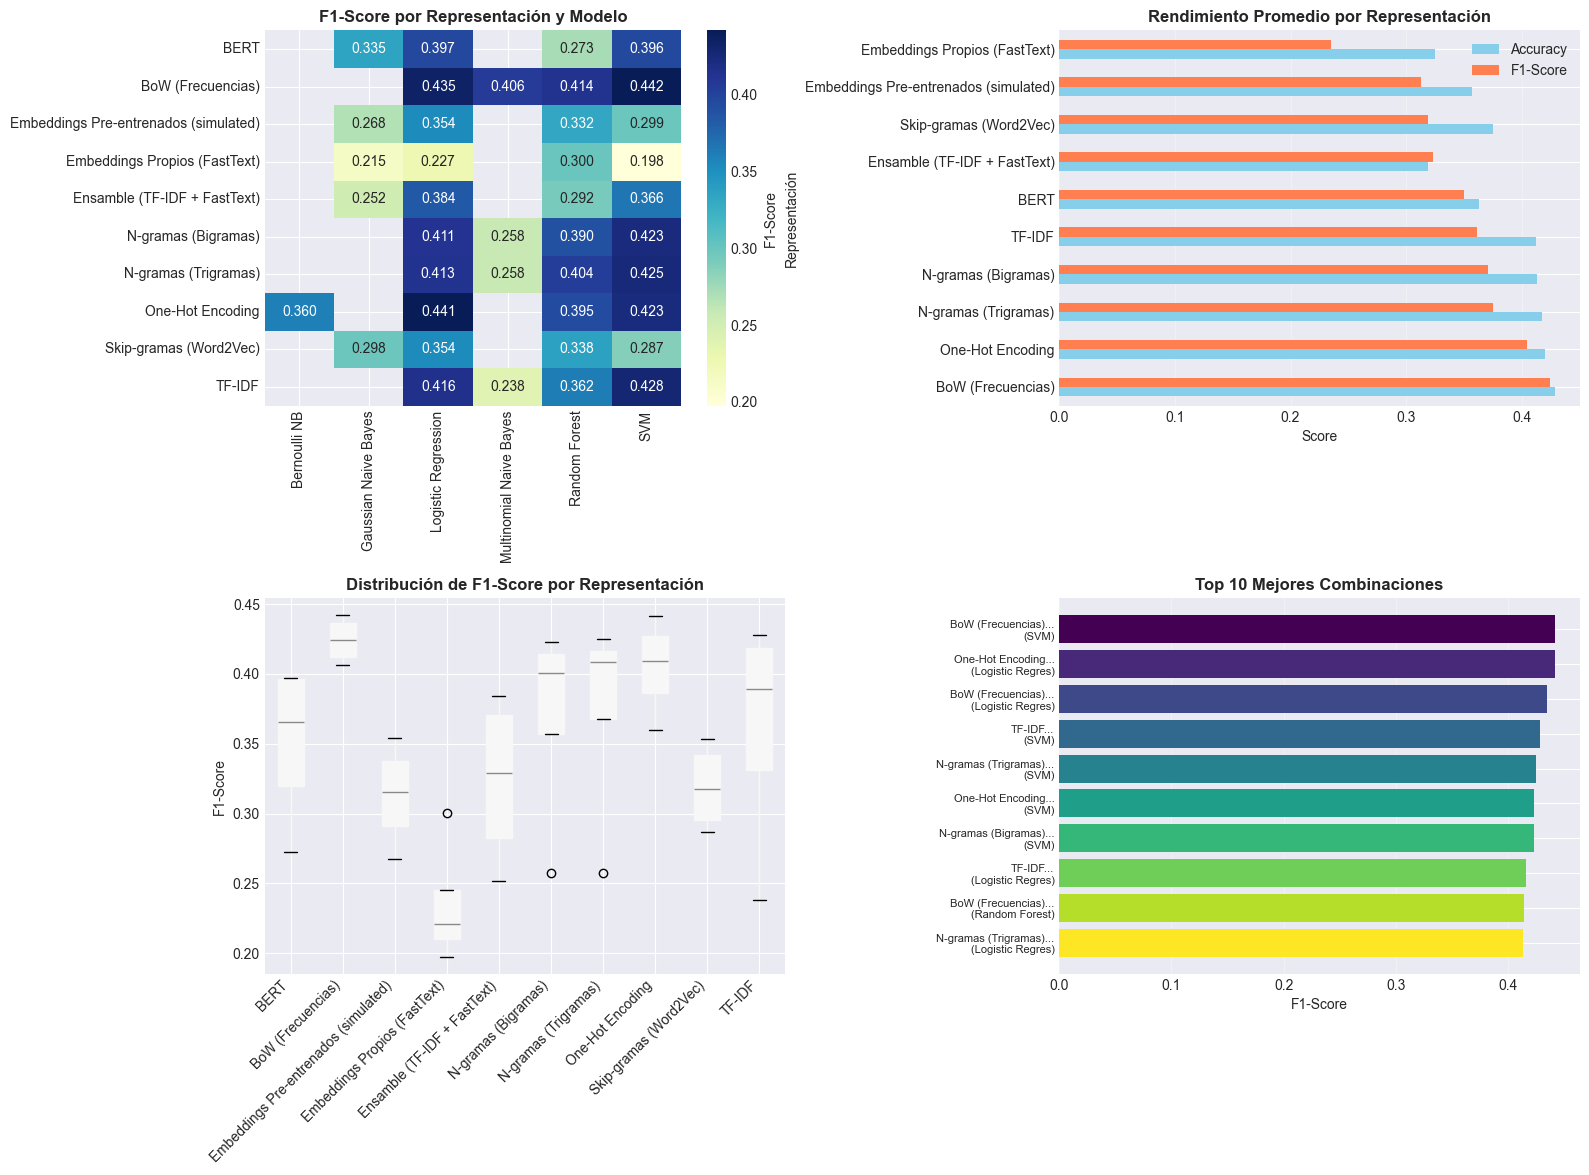

In [96]:
# Visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap de F1-Score por Representación y Modelo
pivot_table = df_resultados.pivot_table(values='F1-Score', index='Representación', columns='Modelo')
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[0, 0], cbar_kws={'label': 'F1-Score'})
axes[0, 0].set_title('F1-Score por Representación y Modelo', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')

# 2. Comparación de representaciones (promedio)
resumen_repr.plot(kind='barh', ax=axes[0, 1], color=['skyblue', 'coral'])
axes[0, 1].set_title('Rendimiento Promedio por Representación', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Score')
axes[0, 1].legend(['Accuracy', 'F1-Score'])
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Box plot de F1-Score por representación
df_resultados.boxplot(column='F1-Score', by='Representación', ax=axes[1, 0], patch_artist=True)
axes[1, 0].set_title('Distribución de F1-Score por Representación', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
plt.suptitle('')

# 4. Top 10 mejores combinaciones
top10 = df_resultados.nlargest(10, 'F1-Score')
top10_labels = [f"{row['Representación'][:20]}...\n({row['Modelo'][:15]})" for _, row in top10.iterrows()]
axes[1, 1].barh(range(len(top10)), top10['F1-Score'], color=plt.cm.viridis(np.linspace(0, 1, len(top10))))
axes[1, 1].set_yticks(range(len(top10)))
axes[1, 1].set_yticklabels(top10_labels, fontsize=8)
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('Top 10 Mejores Combinaciones', fontweight='bold', fontsize=12)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusiones

### Métodos Clásicos vs Modernos

Empezando con lo básico, BoW y One-Hot son súper simples y funcionan decente con Naive Bayes, pero tienen hartos problemas - ignoran completamente el orden de las palabras y la semántica, además de que generan matrices gigantes muy dispersas. One-hot es todavía peor porque ni siquiera cuenta las frecuencias, solo marca presencia/ausencia.

TF-IDF mejora bastante sobre BoW porque le da menos peso a palabras muy comunes y destaca las palabras realmente discriminativas. Es una buena opción como baseline, aunque sigue sin capturar relaciones semánticas entre palabras.

Los n-gramas están interesantes porque sí capturan contexto local y frases completas, super útiles para detectar negaciones como "not good". El problema es que la dimensionalidad explota exponencialmente y los datos se vuelven más dispersos, entonces en un corpus pequeño como este hay riesgo de overfitting.

### Embeddings

Los skip-gramas y Word2Vec son donde empezamos a entrar en representaciones densas más sofisticadas. Capturan similitud semántica (el clásico ejemplo de rey-hombre ≈ reina-mujer) y reducen bastante la dimensionalidad. El problema es que nuestro corpus es muy pequeño entonces los embeddings propios no son de tan buena calidad.

FastText mejora Word2Vec al considerar subpalabras (n-gramas de caracteres), lo cual es perfecto para social media porque es robusto a typos y palabras mal escritas. Los embeddings pre-entrenados como GloVe obviamente funcionarían mejor porque están entrenados en corpus masivos, en producción real definitivamente usaría esos.

### BERT

BERT es estado del arte en NLP con sus representaciones contextuales bidireccionales - la misma palabra puede tener embeddings diferentes según el contexto. Está pre-entrenado en datos masivos y captura semántica profunda. Pero es computacionalmente muy costoso, requiere harta memoria, y honestamente para un dataset tan pequeño como este es overkill. Por eso solo usé una muestra de 1000 tweets.

### Ensambles

El ensamble de TF-IDF + FastText combina lo mejor de ambos mundos: TF-IDF para palabras clave específicas (estadística) y FastText para relaciones semánticas. Lo clave es normalizar ambos con StandardScaler porque tienen rangos muy diferentes. La idea es que TF-IDF funciona bien con vocabulario extenso y FastText generaliza a palabras no vistas, entonces juntos dan mejor cobertura y son más robustos.

### Limitaciones del Dataset

El corpus es bien pequeño y eso limita harto los modelos que requieren más datos como embeddings y BERT. Además son tweets - textos super cortos con lenguaje informal y poco contexto. También hay clases desbalanceadas lo que afecta las métricas, y social media es inherentemente ruidoso.

### Reflexión Final

No hay una representación universal óptima, todo depende del tamaño y calidad del corpus, recursos computacionales disponibles, naturaleza del texto (largo, dominio), el trade-off entre velocidad y precisión, y si necesitas interpretabilidad.

Para este caso específico de tweets cortos en un corpus pequeño, probablemente TF-IDF y n-gramas funcionen mejor que BERT o embeddings complejos que sufren de falta de datos. Si tuviera que ir a producción con recursos limitados, iría con TF-IDF + Logistic Regression por rápido y efectivo. Con más recursos, un ensamble de TF-IDF + embeddings pre-entrenados reales sería lo ideal.

In [97]:
# Guardar resultados completos
# df_resultados.to_csv('resultados_representaciones.csv', index=False)


print("Resumen de experimentos")
print(f"Total de experimentos: {len(df_resultados)}")
print(f"Representaciones evaluadas: {df_resultados['Representación'].nunique()}")
print(f"Modelos evaluados: {df_resultados['Modelo'].nunique()}")
print(f"\nRango de Accuracy: {df_resultados['Accuracy'].min():.4f} - {df_resultados['Accuracy'].max():.4f}")
print(f"Rango de F1-Score: {df_resultados['F1-Score'].min():.4f} - {df_resultados['F1-Score'].max():.4f}")
print("\nTop 3 Representaciones (por F1-Score promedio):")
for i, (repr, row) in enumerate(resumen_repr.head(3).iterrows(), 1):
    print(f"  {i}. {repr}: F1={row['F1-Score']:.4f}, Acc={row['Accuracy']:.4f}")


Resumen de experimentos
Total de experimentos: 40
Representaciones evaluadas: 10
Modelos evaluados: 6

Rango de Accuracy: 0.2351 - 0.4425
Rango de F1-Score: 0.1976 - 0.4418

Top 3 Representaciones (por F1-Score promedio):
  1. BoW (Frecuencias): F1=0.4242, Acc=0.4289
  2. One-Hot Encoding: F1=0.4048, Acc=0.4197
  3. N-gramas (Trigramas): F1=0.3751, Acc=0.4179
